In [2]:
## First step cleaning goal:
# filter papers with english lang, keywords, abstract, references, and issn
# save papers to according published year
# get paper_info dataframe for next step
import re
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import math

In [ ]:

journal_dir = "..\\data\\scopus"
dat = pd.read_csv(journal_dir+'\\'+'journal_subject.csv',keep_default_na = False)

print(dat.dtypes)
all_issn = []
all_issn.append(dat['Print-ISSN'].unique())
all_issn.append(dat['E-ISSN'].unique())
all_issn = [i for sub in all_issn for i in sub]

## Get the dictionary of issn: list of subject
issn_subject = {}
for i in range(dat.shape[0]):

    if dat.iloc[i,5] not in issn_subject:
        issn_subject[dat.iloc[i,5]] = [dat.iloc[i,3]]
    else:
        issn_subject[dat.iloc[i,5]].append(dat.iloc[i,3])
    if dat.iloc[i,6] not in issn_subject:
        issn_subject[dat.iloc[i,6]] = [dat.iloc[i,3]]
    else:
        issn_subject[dat.iloc[i,6]].append(dat.iloc[i,3])
## delete na key
del issn_subject[""]


In [ ]:
data_dir = "..\\data\\"
file_names = os.listdir(data_dir)[:-3]
os.listdir(data_dir)[-3:]

In [ ]:
## set up folder like following
## -data
##   -by_year
##   aminer_paper_0.txt ...

data_dir = "..\\data"
## only keep data file, exclude folds
file_names = os.listdir(data_dir)[:-1]

## output file  
years = np.arange(1990,2019)
out_dir = "..\\data\\by_year"
out_names = ['aminer_'+str(i)+'.txt' for i in years]
out_f = [open(out_dir+'\\'+name, 'w') for name in out_names]

## paper subject table
id_t = []
year_t = []
references_t = []
subjects_t = []
#header = 'id,year,references,issn,subjects\n'
#paper_f = open(out_dir+'\\'+'paper_info.csv','w')
#paper_f.write(header)

for file in file_names:
    print('filtering file:',file)
    f = open(data_dir+'\\'+file,'r',encoding = 'utf8')
    
    for i, line in enumerate(f):
        if (i+2) % 250000 == 0:
            print('file '+file+': ',round((i+2)/1000000*100,1),"%")
        json_line = json.loads(line)
        if 'year' in json_line and 'keywords' in json_line and \
        'abstract' in json_line and 'lang' in json_line and \
        'references' in json_line and 'issn' in json_line:
            
            issn = re.sub('-','',json_line['issn'])
            year = json_line['year']
            if json_line['lang'] == 'en' and issn in issn_subject and \
            year >= 2000 and year <= 2018 :
                
                ## store paper info, later use to get the subject of the paper
                id_t.append(json_line['id'])
                year_t.append(json_line['year'])
                references_t.append(json_line['references'])
                subjects_t.append(issn_subject[issn])
                
                ## write to paper_year
                index = out_names.index('aminer_'+str(year)+'.txt')
                out_f[index].write(line)
    f.close()
    
for out in out_f:
    out.close()


In [ ]:
paper_info = pd.DataFrame({'id':id_t,'year':year_t,'refereneces':references_t,'subjects':subjects_t})
paper_info.to_csv(out_dir+'\\paper_info.csv',index = False)
paper_info.head()

###################### First step cleaning stop here ###########################

In [3]:
## Refer to paper_subject.ipynb for second step
## Second step goal:
##  Use paper_info to get the subject of each paper

################################### DO NOT RUN FOLLOWING BLOCKS #############################
out_dir = "..\\data\\by_year"
paper_info = pd.read_csv(out_dir+'\\paper_info.csv',index_col = 'id')

In [4]:
paper_info.head()

,year,refereneces,subjects
id,,,
53e99784b7602d9701f3e13e,2011,"['53e99b4ab7602d97023ea8fd', '53e997f8b7602d97...","[1308, 1312, 1307]"
53e99784b7602d9701f3e4f2,2002,"['53e9a611b7602d9702f42159', '53e9b316b7602d97...","[2716, 1311, 1313, 1312]"
53e9978db7602d9701f4f415,2005,"['53e9aa41b7602d97033af1b3', '53e9b1b0b7602d97...",[1300]
53e99792b7602d9701f56a86,2004,"['53e9abbeb7602d970356d932', '53e9ad6cb7602d97...",[2738]
53e99792b7602d9701f5b087,2008,"['53e99f9bb7602d970287329d', '53e9abfdb7602d97...","[2503, 2506, 2505, 2508, 2504, 1600, 1503]"


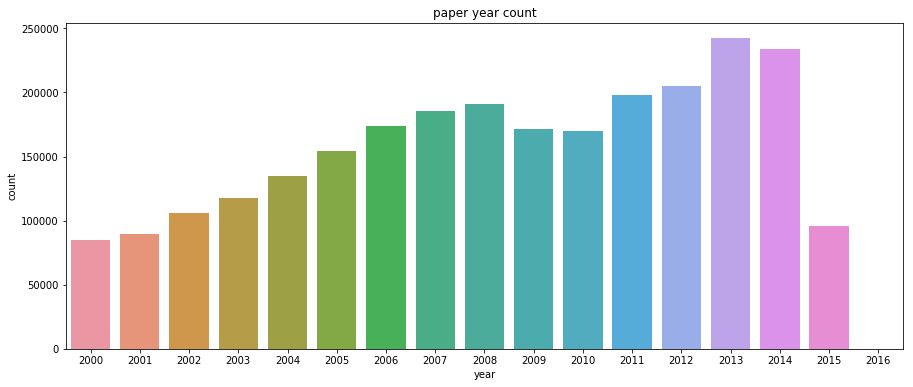

In [19]:
plt.figure(figsize=(15,6))
plt.title("paper year count")
ax = sns.countplot(x = 'year', data = paper_info)

In [21]:
i = 4
def get_subject_num(i):
    ##take in index of paper_info, return 2 digits subject code
    ## if journal has only one subject, return the subject num
    sub_num = [int(s.strip(" [],")) for s in paper_info.iloc[i,2].split(",") if s.strip(" [],") != ""]
    if len(sub_num) == 1:
        return sub_num[0]//100
    else:
        has_ref = False
        subject_list = []
        ref_list = [s.strip(" [],") for s in paper_info.iloc[i,1].split("'") if s.strip(" [],") != ""]
        for ref in ref_list:
            if ref in paper_info.index:
                has_ref = True
                sub_num_list = [int(s.strip(" [],")) for s in paper_info.loc[ref][2].split(",") if s.strip(" [],") != ""]
                subject_list += sub_num 
                count_subject = Counter(np.array(subject_list)//100)
        ## Elements with equal counts are ordered and chose arbitrarily
        if has_ref:
            return count_subject.most_common(1)[0][0]
        else:
            return None
get_subject_num(i)

In [26]:
paper_subject = []
for i in range(paper_info.shape[0]):
    if i == 30000: break
    paper_subject.append(get_subject_num(i))
len(paper_subject)

30000

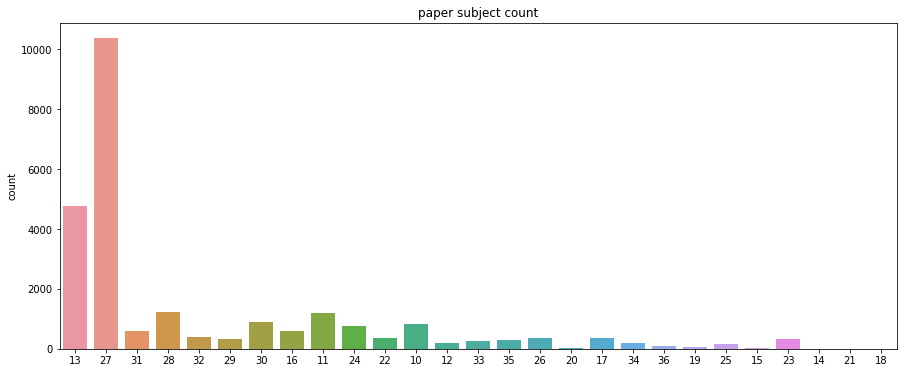

In [27]:
plt.figure(figsize=(15,6))
plt.title("paper subject count")
ax = sns.countplot(x = paper_subject)